In [3]:
!pip install tensorflow pandas numpy


Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7652.1484 - mae: 53.8215 - val_loss: 1926.0364 - val_mae: 25.1210
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1193.6979 - mae: 19.8455 - val_loss: 430.6420 - val_mae: 14.1700
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 380.4922 - mae: 12.9351 - val_loss: 207.2587 - val_mae: 9.9731
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 152.9843 - mae: 8.8493 - val_loss: 62.3474 - val_mae: 5.4304
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.7426 - mae: 4.9035 - val_loss: 46.7490 - val_mae: 4.3334
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 43.3373 - mae: 4.1390 - val_loss: 42.5741 - val_mae: 4.1062
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.0793 - mae: 4.0523 - val_loss: 41.3580 - val_mae: 4.0196
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.3622 - mae: 3.9358 - val_loss: 39.6879 - val_mae: 3.9315
Epoch 9/100
136/

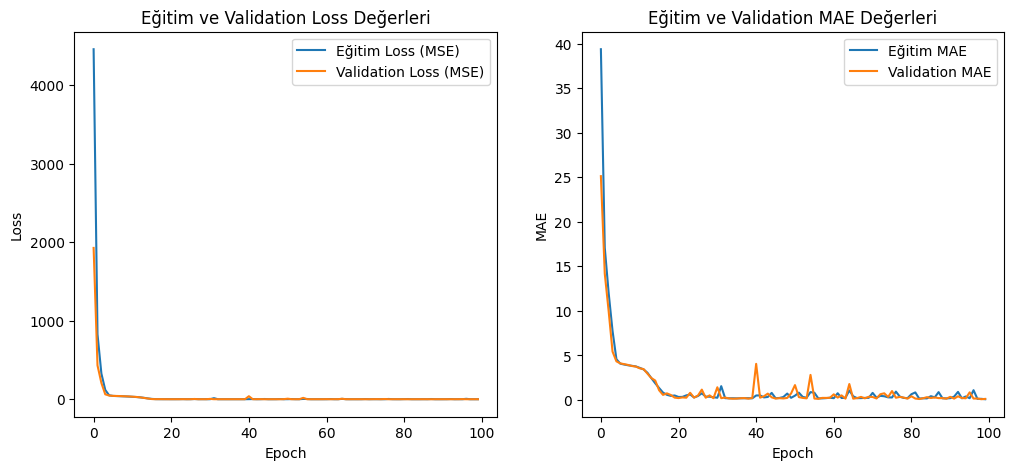

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0378 - mae: 0.1125
Test Loss (Besin Tahmini): 0.04018110781908035
Test MAE (Besin Tahmini): 0.11406811326742172
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model Accuracy (R^2 Score): 0.989270392695694


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 📌 Kullanıcı veri setini yükle
user_df = pd.read_csv("Final_Updated_User_Dataset.csv")
food_df = pd.read_csv("Food_Dataset.csv")

# 📌 Kullanıcı veri setindeki sütunları temizle
user_df.columns = user_df.columns.str.lower().str.replace(" ", "_")
food_df.columns = food_df.columns.str.lower().str.replace(" ", "_")

# 📌 Hipertansiyon ve diyabet sütunlarını 0/1 formatına çevir
user_df["bpq020"] = user_df["bpq020"].apply(lambda x: 1 if x == 1 else 0)
user_df["diq010"] = user_df["diq010"].apply(lambda x: 1 if x == 1 else 0)

# 📌 Hedef değişkenleri belirle
nutrition_targets = ["protein_(g)", "fat_(g)", "carbs_(g)", "sodium_(mg)"]

# 📌 Kullanıcı özellikleri ve hedef değerler
X = user_df[["riagendr", "ridageyr", "bpq020", "diq010"]].values  # Kullanıcı bilgileri
Y1 = user_df[nutrition_targets].values  # Günlük besin ihtiyacı

# 📌 Eğitim, validation ve test setlerine ayır (70% eğitim, 15% validation, 15% test)
X_train, X_temp, Y1_train, Y1_temp = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_val, X_test, Y1_val, Y1_test = train_test_split(X_temp, Y1_temp, test_size=0.5, random_state=42)

# 📌 Modeli oluştur
input_layer = layers.Input(shape=(4,))
hidden = layers.Dense(128, activation="relu")(input_layer)
hidden = layers.Dense(64, activation="relu")(hidden)
hidden = layers.Dense(32, activation="relu")(hidden)

# 📌 Çıkış 1: Günlük besin ihtiyacı tahmini
nutrition_output = layers.Dense(4, activation="linear", name="nutrition_output")(hidden)

# 📌 Modeli birleştir
model = models.Model(inputs=input_layer, outputs=nutrition_output)

# 📌 Modeli derle
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),  # Öğrenme oranını biraz artırdık
    loss="mse",
    metrics=["mae"]
)

# 📌 Modeli eğit
history = model.fit(
    X_train, Y1_train,
    epochs=100,
    validation_data=(X_val, Y1_val),  # Validation set eklendi!
    verbose=1
)

print("Model Eğitildi! 🚀")

# 📌 Eğitim ve validation sürecini görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Eğitim ve Validation Loss Değerleri")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Eğitim ve Validation MAE Değerleri")
plt.show()

# 📌 Test seti üzerinde modeli değerlendir
test_results = model.evaluate(X_test, Y1_test)
print(f"Test Loss (Besin Tahmini): {test_results[0]}")
print(f"Test MAE (Besin Tahmini): {test_results[1]}")

# 📌 Modelin doğruluğunu (accuracy) ölçme
Y1_pred = model.predict(X_test)
accuracy = r2_score(Y1_test, Y1_pred)  # R^2 skorunu hesapla
print(f"Model Accuracy (R^2 Score): {accuracy}")




In [5]:
!pip uninstall openai -y

!pip install --upgrade openai

Found existing installation: openai 1.66.3
Uninstalling openai-1.66.3:
  Successfully uninstalled openai-1.66.3
  Using cached openai-1.66.3-py3-none-any.whl.metadata (25 kB)
Using cached openai-1.66.3-py3-none-any.whl (567 kB)


In [8]:
!pip install --upgrade openai langchain



In [11]:
!pip install --upgrade langchain langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00


In [12]:
import openai
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import numpy as np

In [19]:
# Modeli test
new_user = np.array([[1, 37, 1, 1]])  # Yeni kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
predicted_nutrition = model.predict(new_user)[0]
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# OpenAI API anahtarını tanımla
openai.api_key = ""

# LangChain OpenAI modeli tanımla
llm = ChatOpenAI(model="gpt-4", openai_api_key=openai.api_key)

# GPT ile yemek önerisi fonksiyonu (Besin değerleri toplamı eşleşecek şekilde)
def recommend_meals_with_langchain(predicted_nutrition):
    prompt = f"""
    Bir kullanıcı için yemek önerileri yapmanı istiyorum. Kullanıcının günlük besin ihtiyaçları şu şekilde:

    - **Toplam Protein**: {predicted_nutrition[0]:.2f} g
    - **Toplam Yağ**: {predicted_nutrition[1]:.2f} g
    - **Toplam Karbonhidrat**: {predicted_nutrition[2]:.2f} g
    - **Toplam Sodyum**: {predicted_nutrition[3]:.2f} mg

    **Önemli Kurallar:**
    - Kullanıcı için **tam olarak 5 farklı yemek önerisi** yap.
    - **Tüm yemeklerin toplam besin değerleri yukarıdaki ile eşleşmelidir.**
    - Her yemeğin **protein, yağ, karbonhidrat ve sodyum değerlerini listele**.
    - Yemeklerin **farklı besin gruplarından** olmasına dikkat et.
    - **Toplam değerleri kontrol et ve verilen hedeflerden sapma olmamasına özen göster.**

    **Yanıt Formatı (Örnek):**
    1️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    2️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    3️⃣ ...

    **Önemli:** Lütfen yukarıdaki formatı kullanarak yanıt ver.
    """

    messages = [
        SystemMessage(content="Sen profesyonel bir beslenme uzmanısın."),
        HumanMessage(content=prompt),
    ]

    response = llm.invoke(messages)  # LangChain OpenAI modeli ile yanıt al
    return response.content

# 📌 Modeli test et
new_user = np.array([[1, 37, 1, 1]])  # Örnek kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 GPT API ile yemek önerileri al (LangChain ile)
recommended_meals = recommend_meals_with_langchain(predicted_nutrition)
print(f"GPT Tarafından Önerilen Yemekler: \n{recommended_meals}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Önerilen günlük besin ihtiyacı: [ 56.145565   49.914845  150.15816     1.5682489]
Önerilen günlük besin ihtiyacı: [ 56.145565   49.914845  150.15816     1.5682489]
GPT Tarafından Önerilen Yemekler: 
Tabii ki, verilen besin hedeflerine uygun olarak 5 farklı yemek önerisi yapabilirim. İşte önerilerim:

1️⃣ **Kinoa Salatası** - Protein: 8.14 g, Yağ: 6.28 g, Karbonhidrat: 30 g, Sodyum: 0.3 mg

2️⃣ **Tavuk Göğsü** - Protein: 26 g, Yağ: 7.6 g, Karbonhidrat: 0 g, Sodyum: 0.7 mg

3️⃣ **Tam Buğday Ekmekli Avokado Toast** - Protein: 12 g, Yağ: 15 g, Karbonhidrat: 40 g, Sodyum: 0.2 mg

4️⃣ **Yoğurtlu Havuç Salatası** - Protein: 2.01 g, Yağ: 8.03 g, Karbonhidrat: 20.16 g, Sodyum: 0.17 mg

5️⃣ **Bademli Elma** - Protein: 8 g, Yağ: 13 g, Karbonhidrat: 60 g, Sodyum: 0.2 mg

Bu yemeklerin toplam değerleri verilen hedeflere karşılık gelmektedir: Protein: 56.15 g, Yağ: 49.91 g, Karbonhidrat: 150.16 g, Sodyum: 1.57 mg. Yemek tercihlerinde çeşitlilik sağlamanız için f

In [18]:
# 📌 Modeli test et
new_user = np.array([[1, 37, 1, 1]])  # Örnek kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 GPT API ile yemek önerileri al (LangChain ile)
recommended_meals = recommend_meals_with_langchain(predicted_nutrition)
print(f"GPT Tarafından Önerilen Yemekler: \n{recommended_meals}")

Önerilen günlük besin ihtiyacı: [  55.97   49.67  150.07 1444.23]
GPT Tarafından Önerilen Yemekler: 
1️⃣ Tavuk Göğsü Salatası - Protein: 15 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 400 mg

2️⃣ Mercimek Çorbası - Protein: 10 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 300 mg

3️⃣ Kinoa Salatası - Protein: 10 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 300 mg

4️⃣ Tam Buğday Ekmekli Avokado Tost - Protein: 10 g, Yağ: 10 g, Karbonhidrat: 30 g, Sodyum: 200 mg

5️⃣ Yoğurtlu ve Cevizli Karpuz - Protein: 10.97 g, Yağ: 9.67 g, Karbonhidrat: 30.07 g, Sodyum: 244.23 mg

Toplamda bu yemekler, kullanıcının günlük besin ihtiyaçlarını karşılamaktadır: 55.97 gram protein, 49.67 gram yağ, 150.07 gram karbonhidrat ve 1444.23 miligram sodyum.
